In [1]:
from __future__ import annotations
import time
import tracemalloc
from functools import wraps

from math import sin, cos, exp, pi
from typing import Callable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import norm

In [2]:
# ------------------------------------------------------------
#  Parametry zadania
# ------------------------------------------------------------
m:   float = 3.0
k:   float = 2.5
x0:  float = pi / 6          # punkt startowy
x1:  float = 2 * pi       # punkt końcowy

In [3]:
# ------------------------------------------------------------
#  Funkcje pomocnicze i dokładne rozwiązanie
# ------------------------------------------------------------
def y_exact(x: float | np.ndarray) -> float | np.ndarray:
    return np.exp(-k * np.cos(m * x)) - k * np.cos(m * x) + 1.0

# warunek początkowy
a: float = float(y_exact(x0))


def f_ode(x: float, y: float) -> float:
    return k * m * y * np.sin(m * x) + (k ** 2) * m * np.sin(m * x) * np.cos(m * x)

In [4]:
# ------------------------------------------------------------
#  Dekorator pomiaru czasu i RAM
# ------------------------------------------------------------
times: dict[tuple, float] = {}
mems:  dict[tuple, int]   = {}


def timed_ode(fn):
    @wraps(fn)
    def inner(f: Callable[[float, float], float],
              y0: float,
              t0: float,
              tf: float,
              h: float,
              method: str):
        tracemalloc.start()
        t0_wall = time.perf_counter()

        ts, ys = fn(f, y0, t0, tf, h)

        dt = time.perf_counter() - t0_wall
        _, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        key = (method, h)
        times[key] = dt
        mems[key]  = peak
        return ts, ys
    return inner


In [5]:
# ------------------------------------------------------------
#  Implementacje metod numerycznych
# ------------------------------------------------------------
@timed_ode
def euler_solver(f: Callable[[float, float], float],
                 y0: float, t0: float, tf: float, h: float):
    n_steps = int(np.ceil((tf - t0) / h))
    ts = np.linspace(t0, tf, n_steps + 1, dtype=np.float64)
    ys = np.empty_like(ts)
    ys[0] = y0
    for k_step in range(n_steps):
        ys[k_step + 1] = ys[k_step] + h * f(ts[k_step], ys[k_step])
    return ts, ys


@timed_ode
def rk4_solver(f: Callable[[float, float], float],
               y0: float, t0: float, tf: float, h: float):
    n_steps = int(np.ceil((tf - t0) / h))
    ts = np.linspace(t0, tf, n_steps + 1, dtype=np.float64)
    ys = np.empty_like(ts)
    ys[0] = y0
    for k_step in range(n_steps):
        t, y = ts[k_step], ys[k_step]
        k1 = f(t,         y)
        k2 = f(t + h/2.0, y + h*k1/2.0)
        k3 = f(t + h/2.0, y + h*k2/2.0)
        k4 = f(t + h,     y + h*k3)
        ys[k_step + 1] = y + h * (k1 + 2*k2 + 2*k3 + k4) / 6.0
    return ts, ys

In [6]:
# ------------------------------------------------------------
#  Główna pętla eksperymentów
# ------------------------------------------------------------
def run_experiments(h_vals: tuple[float, ...] | list[float]):
    records: list[dict] = []
    methods = {
        "Euler": euler_solver,
        "RK4":   rk4_solver,
    }

    for h in h_vals:
        for name, solver in methods.items():
            ts, ys_num = solver(f_ode, a, x0, x1, h, name)
            ys_ex  = y_exact(ts)

            err_inf = float(norm(ys_num - ys_ex, ord=np.inf))
            err_l2  = float(norm(ys_num - ys_ex, ord=2) * np.sqrt(h))

            key = (name, h)
            records.append({
                "method":     name,
                "h":          h,
                "n_steps":    len(ts) - 1,
                "time[s]":    times[key],
                "mem[B]":     mems[key],
                "err_inf":    err_inf,
                "err_L2":     err_l2,
                "avg_t_step": times[key] / (len(ts) - 1)
            })

    return pd.DataFrame.from_records(records)

In [7]:
def plot_solutions(ts: np.ndarray,
                   ys_num: np.ndarray,
                   label_num: str,
                   *,
                   show: bool = True):
    # dokładne rozwiązanie na gęstszej siatce
    ts_fine = np.linspace(ts[0], ts[-1], 1000)
    ys_ex_fine = y_exact(ts_fine)

    plt.figure(figsize=(10, 6))
    plt.plot(ts_fine, ys_ex_fine, 'k', lw=2, label='dokładne (gęstsze)')
    plt.plot(ts, ys_num, '.-', label=label_num)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'k={k}, m={m},  x0={x0:.3f},  x1={x1:.3f}')
    plt.legend()
    plt.grid(True)
    if show:
        plt.tight_layout()
        plt.show()

   method       h  n_steps   time[s]  mem[B]    err_inf     err_L2  avg_t_step
0   Euler  0.1000       58  0.001515    2248  38.131948  33.498604    0.000026
1     RK4  0.1000       58  0.006925    1824   0.319636   0.266987    0.000119
2   Euler  0.0500      116  0.004551    2592  35.855269  29.072855    0.000039
3     RK4  0.0500      116  0.017284    3152   0.264275   0.258850    0.000149
4   Euler  0.0100      576  0.015559   10040  16.557752  11.882229    0.000027
5     RK4  0.0100      576  0.057396   10659   0.002921   0.002887    0.000100
6   Euler  0.0050     1152  0.024360   19256   9.500254   6.710072    0.000021
7     RK4  0.0050     1152  0.099974   19376   0.002956   0.002925    0.000087
8   Euler  0.0010     5760  0.120966   92984   2.131771   1.487022    0.000021
9     RK4  0.0010     5760  0.506628   93104   0.002983   0.002953    0.000088
10  Euler  0.0005    11520  0.250665  185144   1.080421   0.752403    0.000022
11    RK4  0.0005    11520  0.991228  185264   0.002

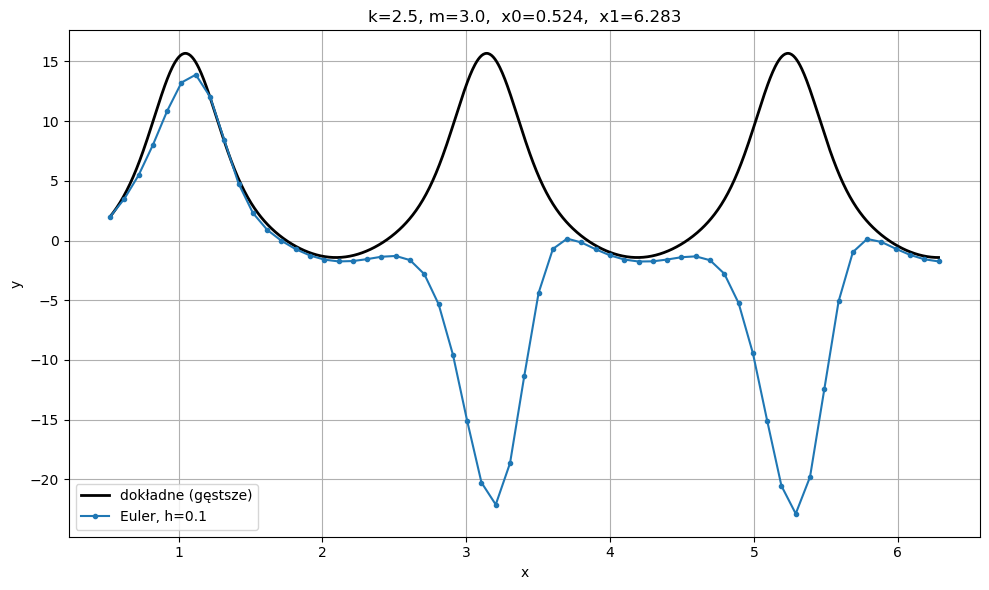

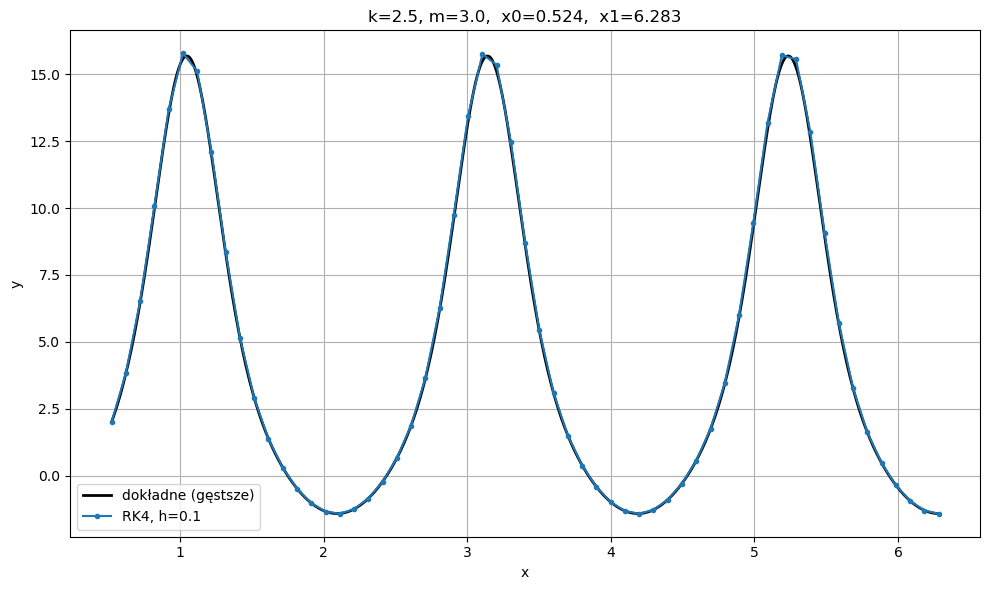

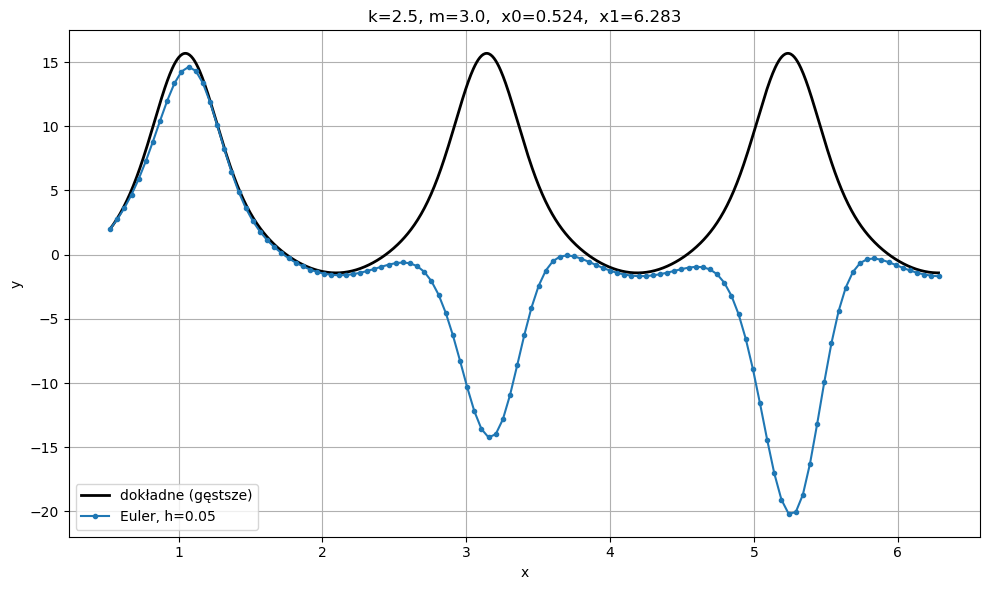

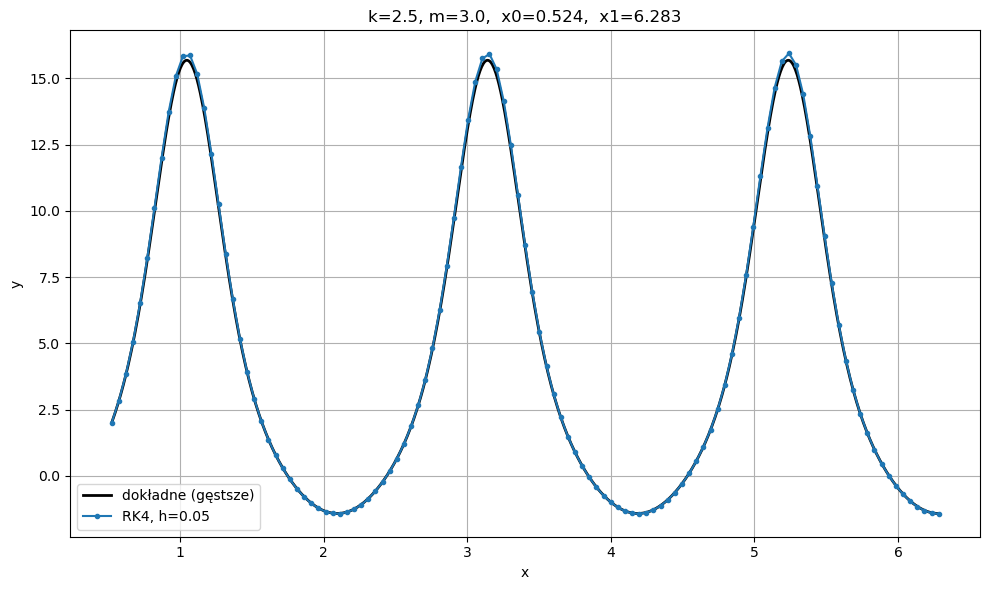

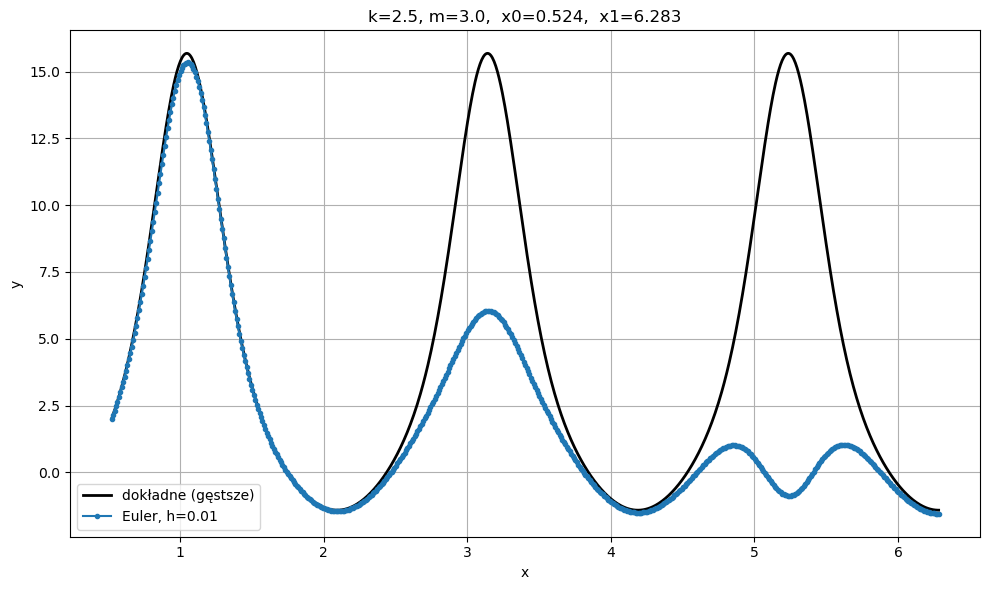

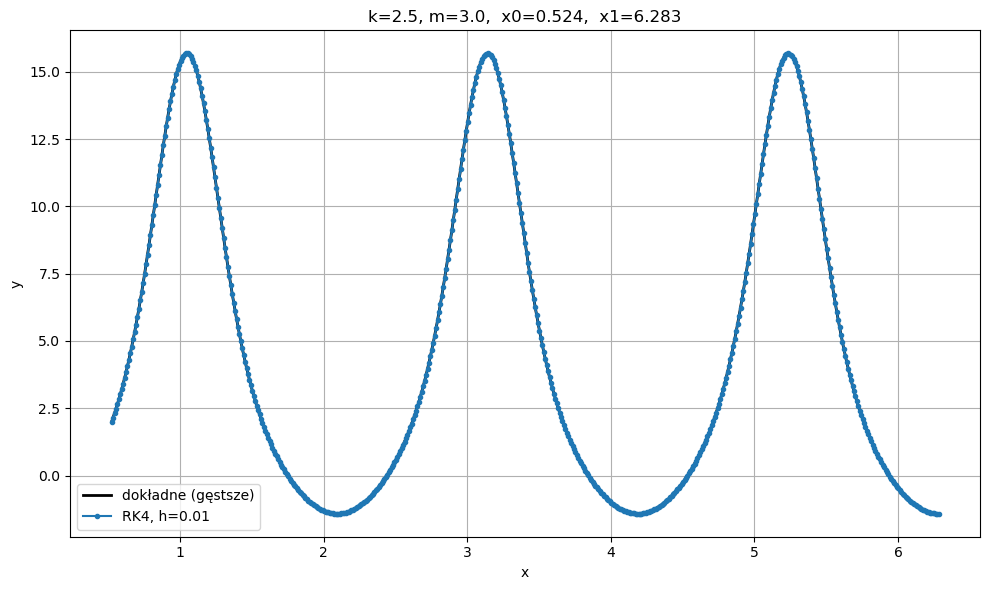

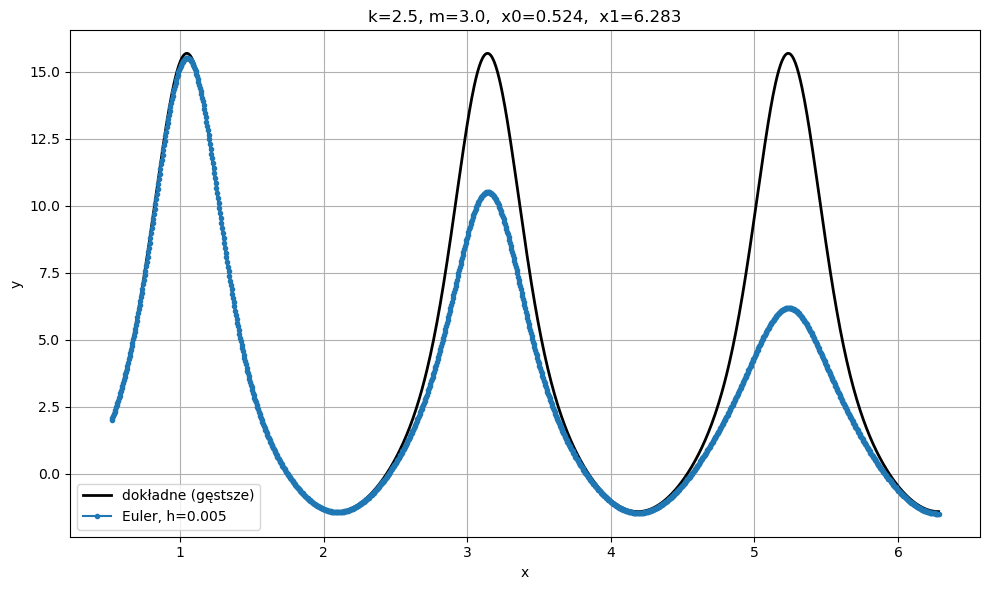

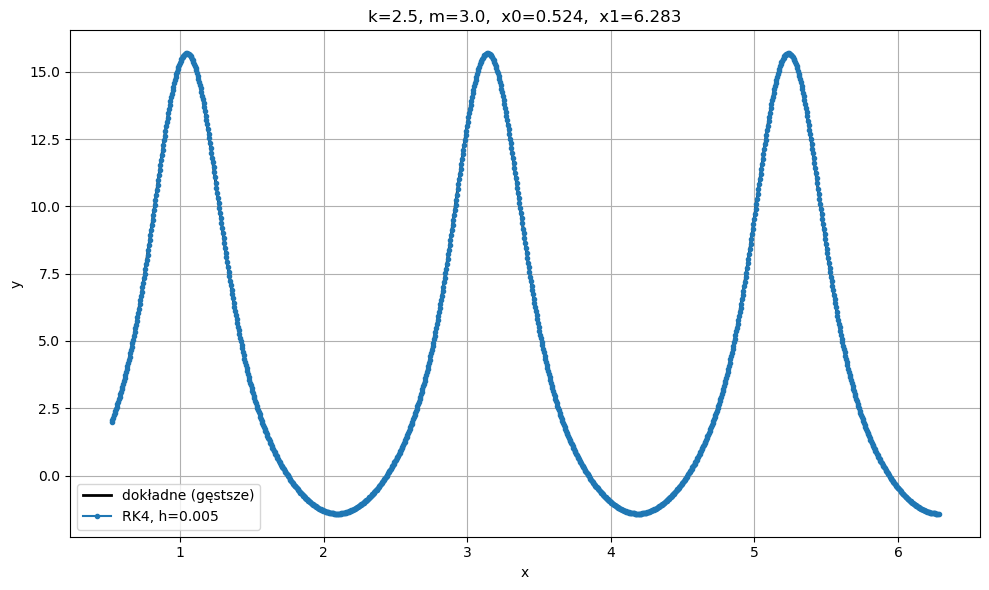

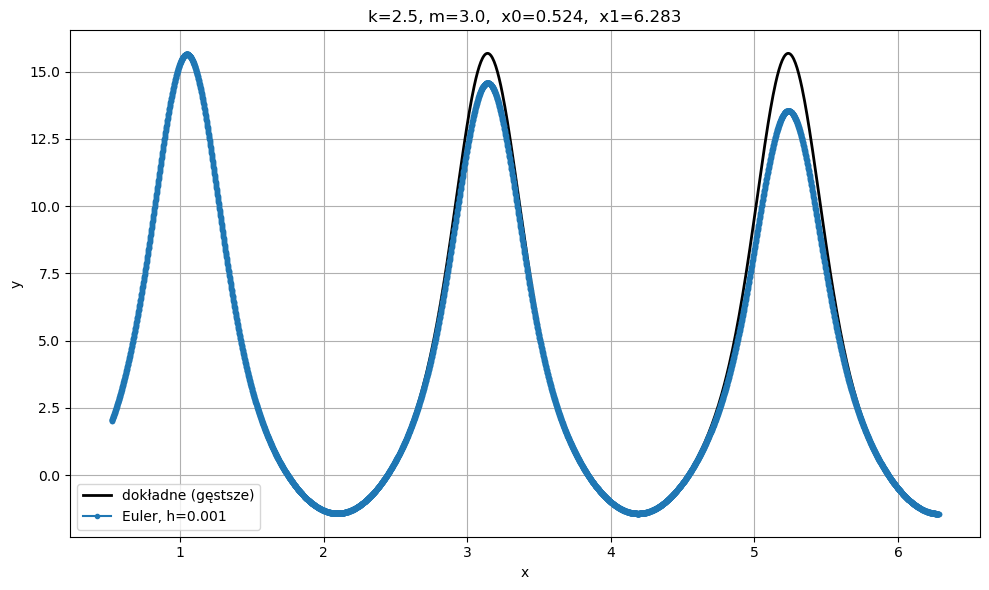

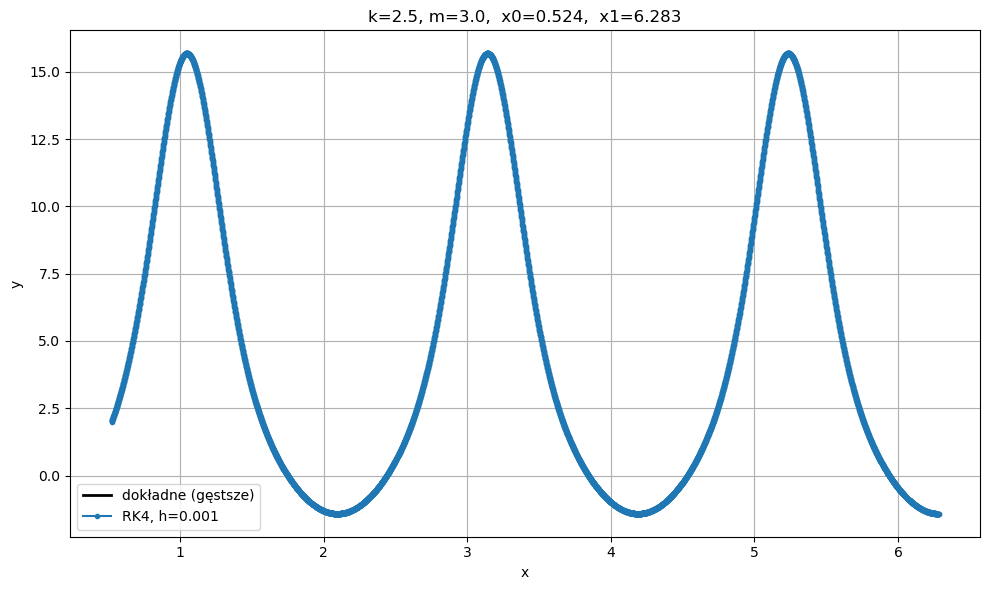

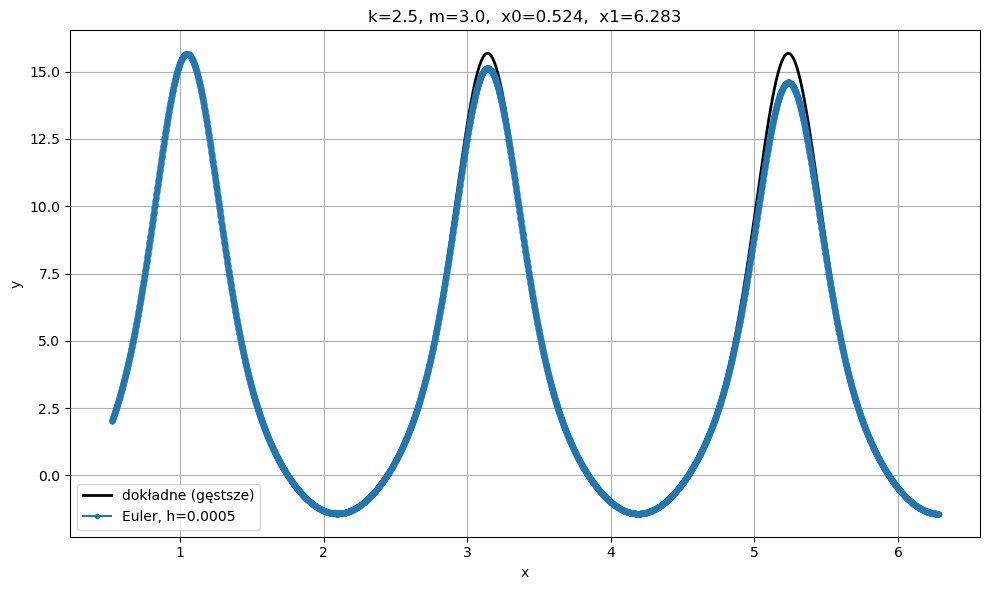

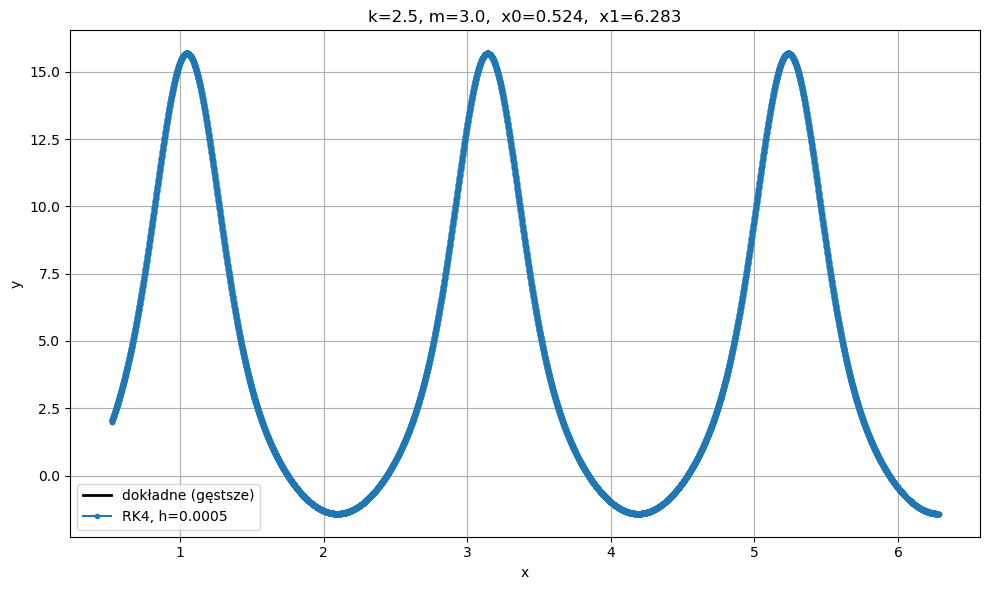

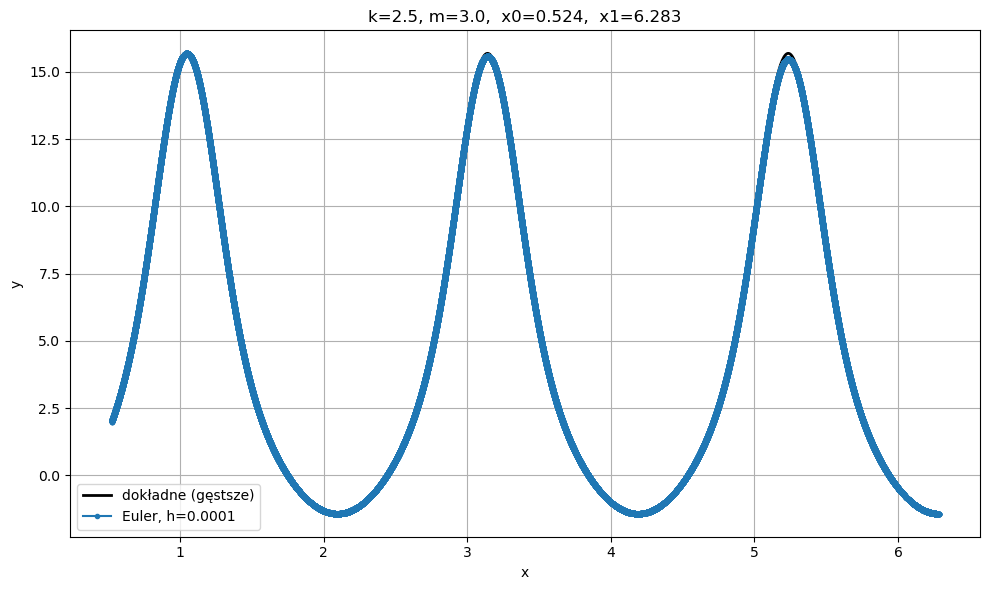

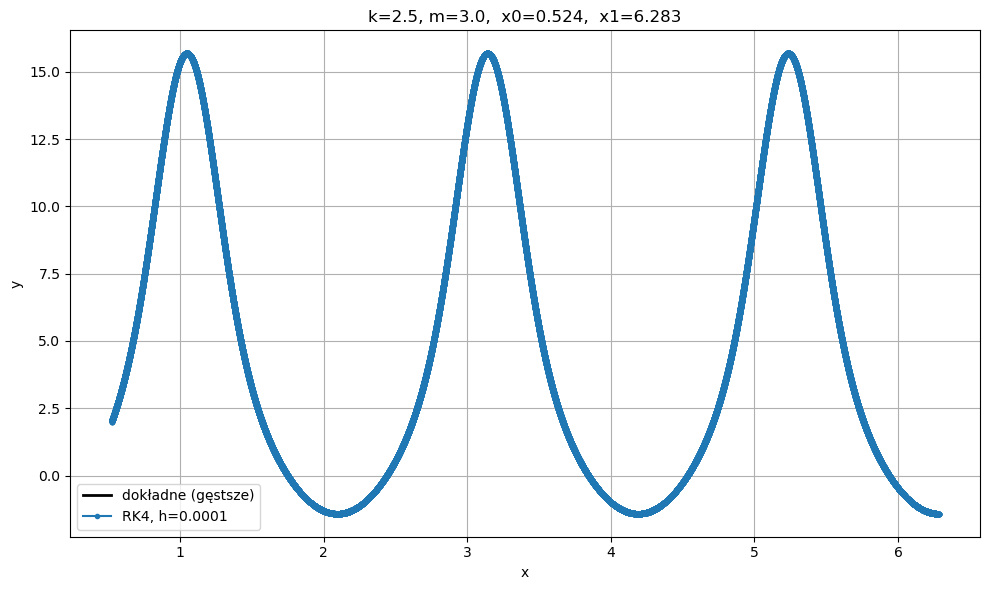

In [8]:
# ------------------------------------------------------------
#  Uruchom tylko gdy plik wykonywany bezpośrednio
# ------------------------------------------------------------
if __name__ == "__main__":
    np.random.seed(42)           # powtarzalność pomiarów

    # kroki testowane (zmieniaj wg potrzeb)
    h_values = [1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4]

    # Eksperymenty i zapis
    df_results = run_experiments(h_values)
    df_results.to_csv(f"ode_results_k{k}_m{m}.csv", index=False)

    # Podgląd wyników w konsoli
    print(df_results)

    # --- Wszystkie przebiegi dla wszystkich h i metod ---
    from itertools import product

    methods = [("Euler", euler_solver),
               ("RK4",   rk4_solver)]

    for h, (method_name, solver) in product(h_values, methods):
        ts_tmp, ys_tmp = solver(f_ode, a, x0, x1, h, method_name)
        plot_solutions(ts_tmp, ys_tmp, f"{method_name}, h={h:g}")